## STFT Code Reuse
This notebook represents my efforts to repurpose Xueling's code.

Here's the code to import my data, which will be referenced as x and y:

In [1]:
# Importing packages
import pandas as pd
smag = __import__('supermag-api')          # SuperMAG python API
logon = 'kd8oxt'                              # SuperMAG ID

import plotly.express as px                # for mapping, mainly
import plotly.graph_objects as go          # for mapping, mainly

import matplotlib.pyplot as plt
import numpy as np

# import os
# # os.environ["CDF_LIB"] = library_directory
# # os.environ["CDF_LIB"] = "~/CDF/lib"          # default "~/CDF/lib"
# from spacepy import pycdf                  # for reading CDF files

# For pulling data from CDAweb:
from ai import cdas
import datetime
from matplotlib import pyplot as plt

# for progress viz:
from tqdm .auto import tqdm
# from tqdm import tqdm_notebook as tqdm
# from tqdm.notebook import trange, tqdm
from IPython.display import clear_output     # Used as a workaround to make tqdm not do silly things

import pickle

from scipy import signal
from scipy.fft import fft

import plotly.graph_objects as go
from plotly.subplots import make_subplots


from magFunctions import *

from matplotlib.dates import DateFormatter


# Fetch station info from .csv and plot on a nice spinnable globe.
conjugate_stations = pd.read_csv('conjugate_stations.csv') # TODO: FIX THIS FILE!
conjugate_stations.Code

stations = pd.read_csv('20220726-04-17-supermag-stations.csv', sep = ',')   # edited version of this spreadsheet
# stations = stations[stations.IAGA.isin(conjugate_stations.Code)] # Plot only the polar stations

# Plot stations:

fig = px.scatter_geo(stations, 
                     lat = stations.GEOLAT,
                     lon = stations.GEOLON,
                     color="OPERATOR", # size of markers, "pop" is one of the columns of gapminder
                     hover_name = "STATION-NAME", 
                     # text = "IAGA"
                     )
fig.update_geos(projection_type="orthographic")
fig.update_layout(height=600, margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()  # uncomment to see mags on globe


# Pull data from 
magname = 'pg4'#'stf'#'skt'#'pg3'#'stf'#'pg4'

parameter = 'MAGNETIC_NORTH_-_H'#'VERTICAL_DOWN_-_Z'
start = datetime.datetime(2016, 1, 25, 0, 0, 0) 
end = datetime.datetime(2016, 1, 25, 13, 0, 0)
# end = start + datetime.timedelta(0, 0, 0, 0, 4096)

# # print('Plotting data for Antarctic magnetometer #' + str(idx+1) + ': ' + magname.upper())
data = cdas.get_data(
    'sp_phys',
    'THG_L2_MAG_'+ magname.upper(),
    start,
    end,
    ['thg_mag_'+ magname]
)
# data['UT'] = pd.to_datetime(data['UT'])#, unit='s')
x =data['UT']
y =data[parameter]


y = reject_outliers(y) # Remove power cycling artifacts on, e.g., PG2.
# y = y - np.nanmean(y)  # Detrend

# Interpolate NaNs away: 
df = pd.DataFrame(y, x)
df = df.interpolate('linear')
y = df[0].values

100% [..........................................................................] 4449948 / 4449948


Here's the code Xueling sent, with minor edits:

In [2]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, stft, spectrogram

#from scipy import signal
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates

import os
import pyspedas
import pytplot

from pytplot import options
from pytplot import get_data

In [3]:
def detrend_arr(data,axis=0):
    #Detrend the data array in a spcific axis
    return data - np.mean(data,axis=0)

def filter_1d(data,order=8,highcut=1./150.,btype='highpass',fs=1, output='sos'):
    #Apply 8th order 150s high-pass filter
    from scipy import signal
    sos = signal.butter(order, highcut, btype=btype, fs=fs, output=output)
    return signal.sosfilt(sos, data)


def filter_signal(data, sample_freq=1./60, lowcut=1e-4, highcut=1e-1, order=3):
    """A convenience method to apply butterworth filters to the data.
       data: array of samples at the given sampling frequency (no gaps)
       sample_freq: sampling frequency that data is given in (Hz)
                    [Default: 1/60 Hz (60 s sample period)]
       lowcut: low cutoff frequency (Hz)
               [Default: 1e-4 Hz, (10,000 s period)]
       highcut: high cutoff frequency (Hz)
                [Default: 1e-1 Hz, (10 s period)]
       order: Order of the butterworth filter to use
              [Default: 3]
    """

    nyquist = 0.5*sample_freq
    low = lowcut / nyquist
    high = highcut / nyquist

    # Create the butterworth filters
    # If the sample frequency is high enough, make it a band pass
    # otherwise, it will be a highpass filter
    # TODO: Might want to add in a low pass filter option?
    #       Or does the bandpass account for that automatically?
    if sample_freq > highcut:
        b, a = butter(order, [low, high], btype='band')
    else:
        b, a = butter(order, low, btype='highpass')

    # Apply the filter coefficients to the data and return
    return filtfilt(b, a, data)

In [4]:
# fname = '20160125_GOES13_B.txt'
# df = pd.read_csv(fname,delim_whitespace=True,\
#                  names=['datetime','Bx','By','Bz','Br','Ba','Bp','Px','Py','Pz'])

In [5]:
# G13_dt = pd.to_datetime(df['datetime'])

In [6]:
# print(G13_dt)

Text(0.5, 0, 'Time [sec]')

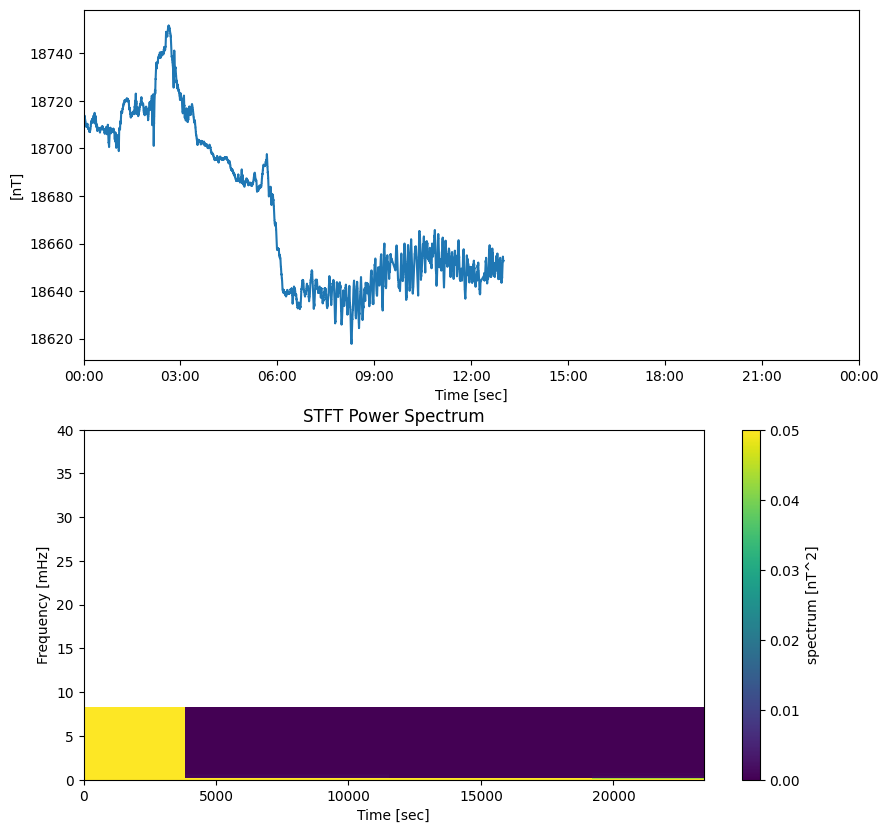

In [7]:
# G13_dt = pd.to_datetime(df['datetime']) # REPLACED THIS WITH X
# G13_Br = df['Br'] # REPLACED THIS WITH Y
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,10))
xlim=[dt.datetime(2016,1,25,0,0),dt.datetime(2016,1,26,0,0)]
# ax1.plot(G13_dt,G13_Br)
ax1.plot(x, y)
ax1.set_ylabel('[nT]') # CHECK: is this the correct unit?
ax1.set_xlabel('Time [sec]')
ax1.set(xlim=xlim)
myFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(myFmt)

# f, t, Zxx = stft(G13_Br, fs=1/0.5, nperseg=1800,noverlap=1200)#
f, t, Zxx = stft(y, fs=1/60)#

cmap=ax2.pcolormesh(t, f*1000., np.abs(Zxx)*np.abs(Zxx), vmin=0, vmax=0.05)
# ax2.axis([0, len(G13_Br)/2., 0, 40])
ax2.axis([0, len(y)/2., 0, 40])
plt.colorbar(cmap,label='spectrum [nT^2]')

ax2.set_title('STFT Power Spectrum')
ax2.set_ylabel('Frequency [mHz]')
ax2.set_xlabel('Time [sec]')

In [8]:
# fil_rstec3 = filter_signal(sanc_vtec, sample_freq=1., lowcut=0.003, highcut=0.020, order=3) #1-20 mHz filter

Text(0.5, 0, 'Time [sec]')

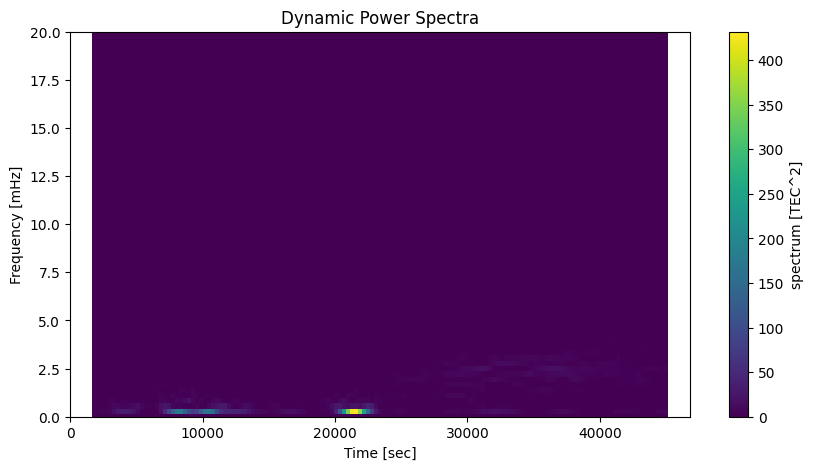

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
# f, t, Sxx = spectrogram(fil_rstec2, fs=1., nperseg=3600,noverlap=3300,scaling='spectrum')#
f, t, Sxx = spectrogram(y, fs=1., nperseg=3600,noverlap=3300,scaling='spectrum')#
plt.pcolormesh(t, f*1000., Sxx)#, vmin=0, vmax=0.05
# plt.axis([0, len(fil_rstec2), 0, 20])
plt.axis([0, len(y), 0, 20])
#plt.colorbar(label='psd [TEC^2/Hz]')
plt.colorbar(label='spectrum [TEC^2]')

plt.title('Dynamic Power Spectra')
plt.ylabel('Frequency [mHz]')
plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time [sec]')

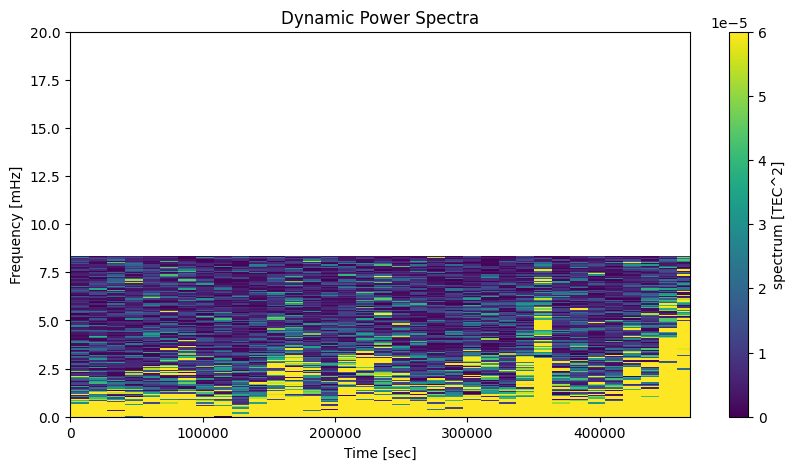

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
# f, t, Sxx = spectrogram(sanc_tec, fs=1., nperseg=3600,noverlap=3300,scaling='spectrum')#
f, t, Sxx = spectrogram(y, fs=1/60., scaling='spectrum')#
plt.pcolormesh(t, f*1000., Sxx, vmin=0, vmax=0.00006)
# plt.axis([0, len(fil_rstec2), 0, 20])
plt.axis([0, len(y)*10, 0, 20])   # I don't understand this line - not sure what the underlying data was.
#plt.colorbar(label='psd [TEC^2/Hz]')
plt.colorbar(label='spectrum [TEC^2]')

plt.title('Dynamic Power Spectra')
plt.ylabel('Frequency [mHz]')
plt.xlabel('Time [sec]')